In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader




In [2]:
! pip install torch

In [3]:
import random
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
set_seed(40)

In [4]:
#Load Data
fully_processed_path = '../data/fully_processed/full_None_None.csv'
dataset = pd.read_csv(fully_processed_path)

#print(dataset.columns)
#print(dataset)

#X, y = dataset.drop(["name", "is_all_star"], axis=1), dataset["is_all_star"]

X = dataset.drop(['name'],axis=1)


In [5]:
#normalize every player feature based on position and season

In [6]:
SEED = 69
train_ratio = 0.3
test_ratio = 0.4
val_ratio = 0.4

X_train, X_tmp = train_test_split(X, test_size=test_ratio+val_ratio)
X_test, X_val = train_test_split(X_tmp,test_size=val_ratio/(val_ratio + test_ratio))

In [7]:

all_stars = X_train[X_train['is_all_star'] == 1]
non_all_stars = X_train[X_train['is_all_star'] == 0]
all_stars = all_stars.sample(n=non_all_stars.shape[0], replace = True)
X_train = pd.concat([all_stars, non_all_stars])
X_train = X_train.sample(frac=1)


In [8]:
#X.head()
X_train[X_train['is_all_star'] == 0]

,age,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,...,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_all_star
8653,30,73,1826,12.1,0.585,0.681,0.138,1.9,12.2,7.1,...,13.4,1.6,2.6,4.2,0.112,-0.5,1.8,1.3,1.5,0
3452,24,81,2246,15.1,0.541,0.278,0.285,3.8,14.6,9.1,...,22.0,3.0,2.3,5.3,0.113,0.6,-0.4,0.2,1.2,0
3044,26,76,1505,7.6,0.430,0.063,0.179,4.1,9.1,6.6,...,12.0,-0.3,1.0,0.7,0.022,-3.6,0.5,-3.2,-0.4,0
2353,23,61,712,9.3,0.495,0.273,0.280,1.5,10.7,6.1,...,15.0,-0.3,0.7,0.5,0.033,-3.4,0.6,-2.8,-0.1,0
1422,23,39,306,6.3,0.281,0.029,0.072,11.3,15.8,13.5,...,12.3,-0.5,0.4,0.0,-0.006,-6.2,1.0,-5.2,-0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8416,24,21,312,10.5,0.531,0.449,0.153,3.9,15.9,9.7,...,15.0,0.1,0.3,0.4,0.064,-2.4,0.0,-2.4,0.0,0
4813,29,27,781,15.1,0.539,0.000,0.346,10.8,21.4,16.2,...,17.2,0.8,0.9,1.7,0.103,-0.3,-0.1,-0.5,0.3,0
2399,24,24,190,7.0,0.525,0.000,0.379,5.4,20.5,12.8,...,22.1,-0.5,0.3,-0.2,-0.040,-9.0,1.1,-7.9,-0.3,0
7361,24,76,2487,20.6,0.630,0.003,0.402,16.6,13.9,15.3,...,16.7,6.7,3.0,9.7,0.187,1.7,-0.6,1.1,2.0,0


In [9]:
'''
#split dataset into 60/20/20 for training, testing, validation
SEED = 69
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2



X, y = X.drop(columns=['is_all_star']), X['is_all_star']

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=test_ratio+val_ratio)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=val_ratio/(val_ratio + test_ratio))
'''
X_train, y_train = X_train.drop(columns=['is_all_star']), X_train['is_all_star']
X_test, y_test = X_test.drop(columns=['is_all_star']), X_test['is_all_star']
X_val, y_val = X_val.drop(columns=['is_all_star']), X_val['is_all_star']

#convert data to tensors
X_train, X_test, X_val = torch.LongTensor(X_train.values), torch.LongTensor(X_test.values), torch.LongTensor(X_val.values)
y_train, y_test, y_val = torch.LongTensor(y_train.values), torch.LongTensor(y_test.values), torch.LongTensor(y_val.values)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

torch.Size([3560, 23]) torch.Size([3799, 23]) torch.Size([3800, 23])
torch.Size([3560]) torch.Size([3799]) torch.Size([3800])


In [10]:
class dataset(Dataset):
  def __init__(self,X,y):
    self.X = X.float()
    self.y = y.float()
    self.length = self.X.shape[0]
 
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]
  def __len__(self):
    return self.length

In [11]:
class AllStarClassifier(nn.Module):
    def __init__(self, LAYER_1=30, LAYER_2=10, LAYER_3 = 10, LAYER_4 = 10):
      super(AllStarClassifier, self).__init__()
      # dense layers
      self.layer1 = nn.Linear(LAYER_1, LAYER_2)
      self.layer2 = nn.Linear(LAYER_2,  LAYER_3)
      self.layer3 = nn.Linear(LAYER_3,  LAYER_4)
      self.layer4 = nn.Linear(LAYER_4,  1)

    def forward(self, X):

      X = self.layer1(X)
      X = F.relu(X)
      X = self.layer2(X)
      X = F.relu(X)
      X = self.layer3(X)
      X = F.relu(X)
      X = self.layer4(X)
      return torch.sigmoid(X)

In [12]:
loss_fn = nn.BCELoss()

learning_rate = 0.1
num_epochs = 10
batch_size = 16

In [13]:
train_set = dataset(X_train,y_train)
test_set = dataset(X_test,y_test)
val_set = dataset(X_val,y_val)
#DataLoader
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)

In [14]:
def EvalNet(dev_loader, net):
    num_correct = 0
    epoch_accuracy = []
    epoch_loss = []
    y_pred = []
    y_actual = []
    for i,(X,y) in enumerate(dev_loader):
        output = net.forward(X)

        loss = loss_fn(output,y.reshape(-1,1))
        epoch_loss.append(loss.detach().numpy())

        #get pred and actual values
        y_pred.append(output.detach().numpy().round().reshape((output.shape[0])))
        y_actual.append(y.detach().numpy().reshape((y.shape[0])))

        accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/X.shape[0]
        epoch_accuracy.append(accuracy)

    eval_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    eval_accuracy_list.append(sum(epoch_accuracy) / len(epoch_accuracy))

    y_pred = np.concatenate(y_pred)
    y_actual = np.concatenate(y_actual)

    print("Accuracy: %s" % (sum(epoch_accuracy) / len(epoch_accuracy)))

    return y_actual, y_pred

def Metrics(dev_loader, net):
  y, y_pred = EvalNet(dev_loader, net)
  conversion_dict = {0: 'Non-All-Star' ,1: 'All-Star'}
  processed_y, processed_y_pred = [],[]
  for i in range(len(y)):
    processed_y.append(conversion_dict[y[i]])
    processed_y_pred.append(conversion_dict[y_pred[i]])
  print(classification_report(processed_y, processed_y_pred, labels=['Non-All-Star', 'All-Star']))

def Train(net, train_loader, n_iter, dev_loader, learning_rate=0.01):
  print("Start Training!")
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  for epoch in range(n_iter):
    total_loss = 0.0
    epoch_accuracy = []
    epoch_loss = []
    net.train()   #Put the network into training mode
    for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):
      output = net(X)
      
      loss = loss_fn(output,y.reshape(-1,1))
      epoch_loss.append(loss.detach().numpy())

      accuracy = (output.reshape(-1).detach().numpy().round() == y.detach().numpy()).sum()/(X.shape[0])
      epoch_accuracy.append(accuracy)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      

    train_accuracy_list.append(sum(epoch_accuracy)/len(epoch_accuracy))
    train_loss_list.append(sum(epoch_loss)/len(epoch_loss))
    
    net.eval()
    with torch.no_grad():
      print(f"Loss on Train {epoch} = {sum(epoch_loss)/len(epoch_loss)}")
      Metrics(dev_loader, net)
  return net

In [15]:
set_seed(100)

eval_loss_list = []
train_loss_list = []
eval_accuracy_list = []
train_accuracy_list = []

as_classifier = AllStarClassifier(LAYER_1=X_train.shape[1], LAYER_2=30, LAYER_3=15, LAYER_4=5)
trained_nn = Train(as_classifier, train_loader, num_epochs, val_loader)


Start Training!


/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 0 = 0.5353066163145908
Accuracy: 0.7738970588235294
              precision    recall  f1-score   support

Non-All-Star       1.00      0.77      0.87      3607
    All-Star       0.18      0.94      0.30       193

    accuracy                           0.77      3800
   macro avg       0.59      0.85      0.58      3800
weighted avg       0.95      0.77      0.84      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 1 = 0.29599030546409666
Accuracy: 0.9330357142857143
              precision    recall  f1-score   support

Non-All-Star       0.99      0.94      0.96      3607
    All-Star       0.42      0.89      0.57       193

    accuracy                           0.93      3800
   macro avg       0.71      0.91      0.77      3800
weighted avg       0.96      0.93      0.94      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 2 = 0.19498692072025864
Accuracy: 0.8792016806722689
              precision    recall  f1-score   support

Non-All-Star       1.00      0.87      0.93      3607
    All-Star       0.29      0.98      0.45       193

    accuracy                           0.88      3800
   macro avg       0.65      0.93      0.69      3800
weighted avg       0.96      0.88      0.91      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 3 = 0.1787925328466323
Accuracy: 0.9338235294117647
              precision    recall  f1-score   support

Non-All-Star       1.00      0.93      0.96      3607
    All-Star       0.43      0.93      0.59       193

    accuracy                           0.93      3800
   macro avg       0.71      0.93      0.78      3800
weighted avg       0.97      0.93      0.94      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 4 = 0.19550806496943862
Accuracy: 0.835609243697479
              precision    recall  f1-score   support

Non-All-Star       1.00      0.83      0.91      3607
    All-Star       0.23      0.99      0.38       193

    accuracy                           0.84      3800
   macro avg       0.62      0.91      0.64      3800
weighted avg       0.96      0.84      0.88      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 5 = 0.1703230688189712
Accuracy: 0.8529411764705882
              precision    recall  f1-score   support

Non-All-Star       1.00      0.85      0.92      3607
    All-Star       0.26      0.99      0.41       193

    accuracy                           0.85      3800
   macro avg       0.63      0.92      0.66      3800
weighted avg       0.96      0.85      0.89      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 6 = 0.1635461298314512
Accuracy: 0.9017857142857143
              precision    recall  f1-score   support

Non-All-Star       1.00      0.90      0.95      3607
    All-Star       0.34      0.97      0.50       193

    accuracy                           0.90      3800
   macro avg       0.67      0.94      0.72      3800
weighted avg       0.96      0.90      0.92      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 7 = 0.18970341955816933
Accuracy: 0.9380252100840336
              precision    recall  f1-score   support

Non-All-Star       1.00      0.94      0.97      3607
    All-Star       0.45      0.93      0.61       193

    accuracy                           0.94      3800
   macro avg       0.72      0.94      0.79      3800
weighted avg       0.97      0.94      0.95      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 8 = 0.16043961843717927
Accuracy: 0.9296218487394958
              precision    recall  f1-score   support

Non-All-Star       1.00      0.93      0.96      3607
    All-Star       0.42      0.94      0.58       193

    accuracy                           0.93      3800
   macro avg       0.71      0.93      0.77      3800
weighted avg       0.97      0.93      0.94      3800



/var/folders/v4/j3sr0tsj41l028ps5j38z4fw0000gn/T/ipykernel_33845/1717566840.py:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,(X,y) in tqdm.tqdm_notebook(enumerate(train_loader)):


0it [00:00, ?it/s]

Loss on Train 9 = 0.15661990665517447
Accuracy: 0.9338235294117647
              precision    recall  f1-score   support

Non-All-Star       1.00      0.93      0.96      3607
    All-Star       0.43      0.93      0.59       193

    accuracy                           0.93      3800
   macro avg       0.71      0.93      0.78      3800
weighted avg       0.97      0.93      0.95      3800



In [16]:
print(dir(tqdm.tqdm_notebook))
print('tqdm_notebook' in dir(tqdm))
print(dir(tqdm.tqdm_notebook))

['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
True
['__annotations__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [17]:
train_loss_list

[0.5353066163145908,
 0.29599030546409666,
 0.19498692072025864,
 0.1787925328466323,
 0.19550806496943862,
 0.1703230688189712,
 0.1635461298314512,
 0.18970341955816933,
 0.16043961843717927,
 0.15661990665517447]

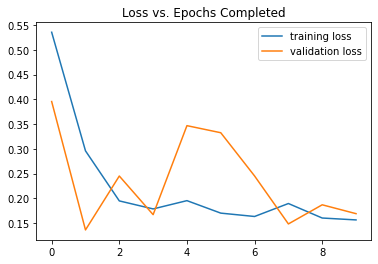

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss_list, label='training loss')
plt.plot(eval_loss_list, label='validation loss')
plt.title('Loss vs. Epochs Completed')
plt.legend()

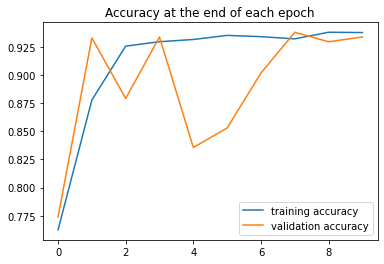

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_accuracy_list, label='training accuracy')
plt.plot(eval_accuracy_list, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()